In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython.display import clear_output

Download the caltech_birds2011 dataset

In [2]:
dataset, info = tfds.load('caltech_birds2011:0.*.*', with_info=True)

# Preprocessing data
Change input_image type to float32 and normalize it to [0,1]

Normalize input_mask to [0,1]

In [3]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

Resize datapoint['image'] to (128,128)

Resize datapoint['segmentation_mask'] to (128,128)

Flip images from left to right

In [4]:
@tf.function
def load_image_train(datapoint):
  #Resize
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    #Flip
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [5]:
def load_image_test(datapoint):
  #Resize
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [7]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [8]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i>0:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]),cmap='gray')
    else:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

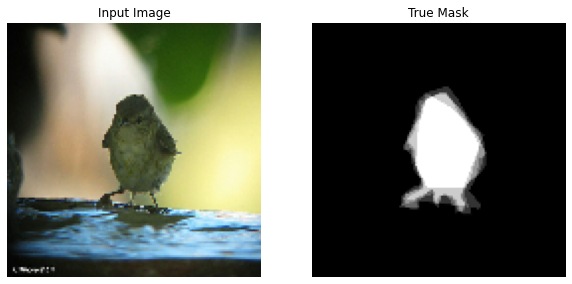

In [9]:
for image, mask in train.take(6):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

# U-net architecture

Encoder | Bottleneck | Decoder
--- | --- | ---
CL(32,4,2) | CR(256,4,2) | TBDR(256,4,2)
CBL(64,4,2) |  | TBDR(128,4,2)
CBL(128,4,2) |  | TBR(64,4,2)
CBL(256,4,2) |  | TBR(32,4,2)
| | TS(1,4,2)

 Acronyms: C=convolution, B=batch normalization, L= leaky relu(alpha=0.2), D=dropout, R=relu,
T=transpose convolution, S=sigmoid. 

The numbers in parentheses indicate the number of ﬁlters, ﬁlter size, and stride of the convolution
ﬁlters, respectively.

Initialize weights with mean=0 and Standard deviation=0.02

In [10]:
from tensorflow.keras.initializers import RandomNormal 
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Dropout, LeakyReLU

In [11]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add convolution layer
	x = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		x = BatchNormalization()(x, training=True)
	# leaky relu activation
	x = LeakyReLU(alpha=0.2)(x)
	return x

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add transpose convolution layer
	x = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	x = BatchNormalization()(x, training=True)
	# conditionally add dropout
	if dropout:
		x = Dropout(0.5)(x, training=True)
	# merge with skip connection
	x = tf.keras.layers.Concatenate()([x, skip_in])
	# relu activation
	x = LeakyReLU(alpha=0.2)(x)
	return x

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   1568        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

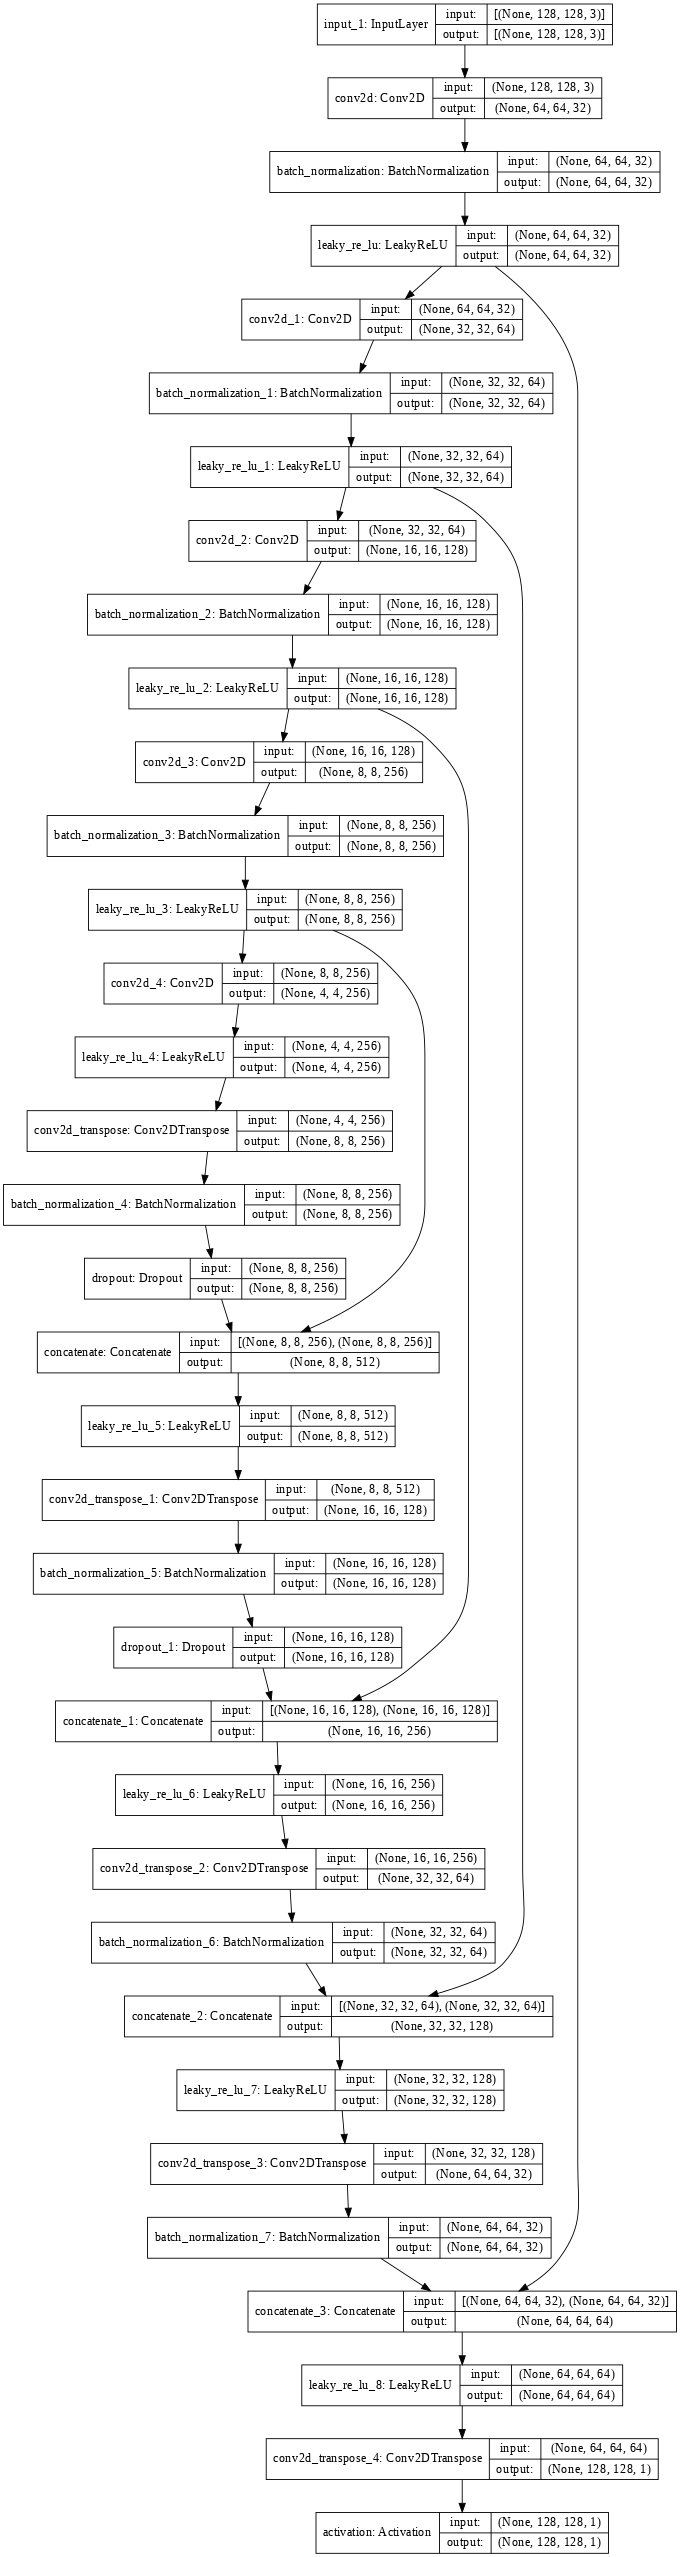

In [12]:
# define the Unet model
def Unet():
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = tf.keras.layers.Input(shape=[128,128,3])
    # encoder model
    e1 = define_encoder_block(in_image, 32)
    e2 = define_encoder_block(e1, 64, batchnorm=True)
    e3 = define_encoder_block(e2, 128, batchnorm=True)
    e4 = define_encoder_block(e3, 256, batchnorm=True)

    # bottleneck, conv and relu activation
    b = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e4)
    b = LeakyReLU(alpha=0.2)(b)

    # decoder model
    d1 = decoder_block(b, e4, 256)
    d2 = decoder_block(d1, e3, 128)
    d3 = decoder_block(d2, e2, 64, dropout=False)
    d4 = decoder_block(d3, e1, 32, dropout=False)

    # Conv2D Transpose
    g = Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d4)

    # Sigmoid activation
    out_image = Activation('tanh')(g)
    # define model
    model = tf.keras.Model(in_image, out_image)
    return model

Unet = Unet()
Unet.summary()
tf.keras.utils.plot_model(Unet, show_shapes=True, dpi=64)

# Compile the model
Use Adam optimizer with learning rate 0.001 and BinaryCrossentropy with from_logits=True

Set accuracy for metrics

In [34]:
Unet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# Fit the model

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5 
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

#Complete with train_data, epochs, steps_per_epoch, validation_steps, validation_data
model_history = Unet.fit(train_dataset,
                         batch_size=32,
                         epochs=EPOCHS,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         validation_steps=VALIDATION_STEPS,
                         validation_data=test_dataset)

Epoch 1/20
93/93 [==============================] - 10s 100ms/step - loss: -31.9215 - accuracy: 0.0000e+00 - val_loss: -32.0668 - val_accuracy: 0.0000e+00
Epoch 2/20
93/93 [==============================] - 9s 97ms/step - loss: -32.0584 - accuracy: 0.0000e+00 - val_loss: -32.0780 - val_accuracy: 0.0000e+00
Epoch 3/20
93/93 [==============================] - 9s 97ms/step - loss: -32.3745 - accuracy: 0.0000e+00 - val_loss: -32.0950 - val_accuracy: 0.0000e+00
Epoch 4/20
93/93 [==============================] - 9s 98ms/step - loss: -32.2155 - accuracy: 0.0000e+00 - val_loss: -32.1432 - val_accuracy: 0.0000e+00
Epoch 5/20
93/93 [==============================] - 9s 98ms/step - loss: -32.6752 - accuracy: 0.0000e+00 - val_loss: -32.1822 - val_accuracy: 0.0000e+00
Epoch 6/20
93/93 [==============================] - 9s 98ms/step - loss: -32.0838 - accuracy: 0.0000e+00 - val_loss: -32.1752 - val_accuracy: 0.0000e+00
Epoch 7/20
93/93 [==============================] - 9s 98ms/step - loss: -32.378

Draw loss and validation loss history

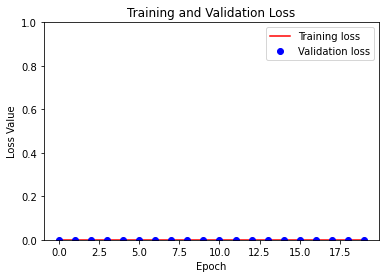

In [30]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Predict
Draw predict images

In [31]:
def show_predictions(dataset, num=10):
  for image, mask in dataset.take(num):
      #Prediction

      input_image = tf.image.resize(image, (128, 128))
      input_mask = tf.image.resize(mask, (128, 128))

      image, mask = normalize(input_image, input_mask)
      pred_mask = Unet.predict(image)
      #insert your code here
      display([image[0], mask[0], pred_mask[0]])

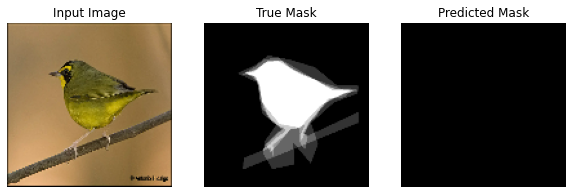

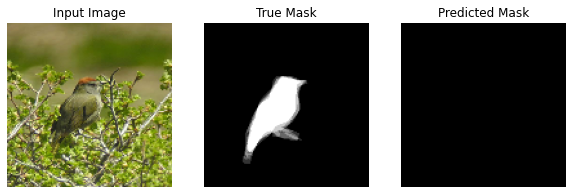

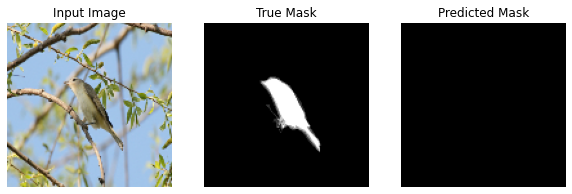

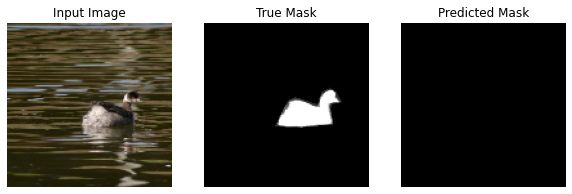

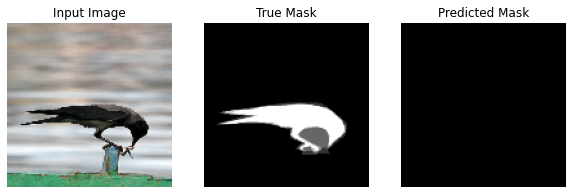

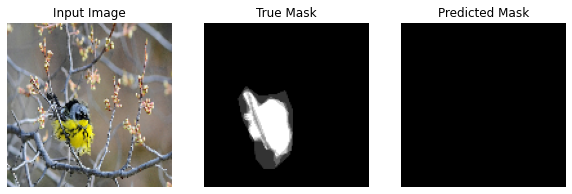

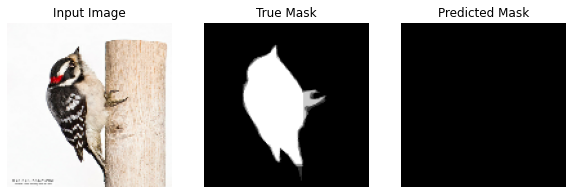

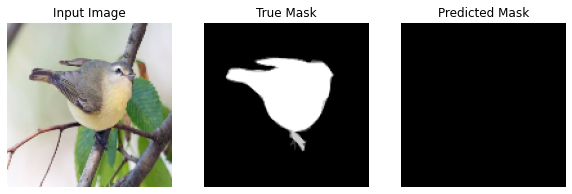

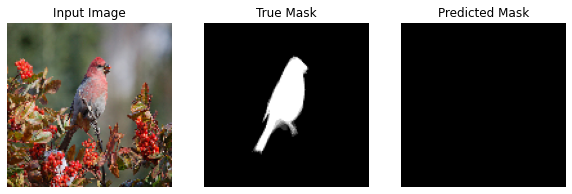

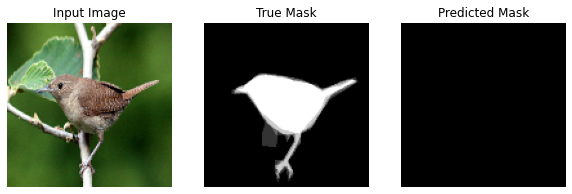

In [32]:
show_predictions(test_dataset)